#### The datasets in which we will be using here were obtained via open sources.

---

Let's begin with importing our needed libraries.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

Next, let's load in our training vehicle dataset.

In [2]:
train = pd.read_csv('./data/vehicles_train.csv')

Now, let's check out the data.

In [3]:
train.sample(5)

,price,year,miles,doors,vtype
12,1800,1999,163000,2,truck
4,9000,2007,47000,4,car
1,14000,2010,30000,2,car
9,1900,2003,160000,4,car
13,1300,1997,138000,4,car


In [4]:
train.isnull().sum()

price    0
year     0
miles    0
doors    0
vtype    0
dtype: int64

In [5]:
# Before splitting anything, let's just predict the mean of the entire data set #
train['prediction'] = train.price.mean()

In [6]:
# Let's calculate the RMSE for those predictions #
np.sqrt(metrics.mean_squared_error(train.price, train.prediction))

5936.981985995983

In [7]:
# Let's create a function that calculates the RMSE for a given split of miles #
def mileage_split(miles):
    lower_mileage_price = train[train.miles < miles].price.mean()
    higher_mileage_price = train[train.miles >= miles].price.mean()
    train['prediction'] = np.where(train.miles < miles, lower_mileage_price, higher_mileage_price)
    return np.sqrt(metrics.mean_squared_error(train.price, train.prediction))

In [8]:
# Let's calculate the RMSE for a tree that splits on miles < 50,000 #
print('RMSE:', mileage_split(50000))
train

RMSE: 3984.0917425414564


,price,year,miles,doors,vtype,prediction
0,22000,2012,13000,2,car,15000.000000
1,14000,2010,30000,2,car,15000.000000
2,13000,2010,73500,4,car,4272.727273
3,9500,2009,78000,4,car,4272.727273
4,9000,2007,47000,4,car,15000.000000
5,4000,2006,124000,2,car,4272.727273
6,3000,2004,177000,4,car,4272.727273
7,2000,2004,209000,4,truck,4272.727273
8,3000,2003,138000,2,car,4272.727273
9,1900,2003,160000,4,car,4272.727273


In [9]:
# Let's calculate the RMSE for a tree that splits on miles < 100,000 #
print('RMSE:', mileage_split(100000))
train

RMSE: 3530.146530076269


,price,year,miles,doors,vtype,prediction
0,22000,2012,13000,2,car,12083.333333
1,14000,2010,30000,2,car,12083.333333
2,13000,2010,73500,4,car,12083.333333
3,9500,2009,78000,4,car,12083.333333
4,9000,2007,47000,4,car,12083.333333
5,4000,2006,124000,2,car,2437.500000
6,3000,2004,177000,4,car,2437.500000
7,2000,2004,209000,4,truck,2437.500000
8,3000,2003,138000,2,car,2437.500000
9,1900,2003,160000,4,car,2437.500000


In [10]:
# Let's check out all the possible mileage splits #
mileage_range = list(range(train.miles.min(), train.miles.max(), 1000))
RMSE = []
for miles in mileage_range:
    RMSE.append(mileage_split(miles))

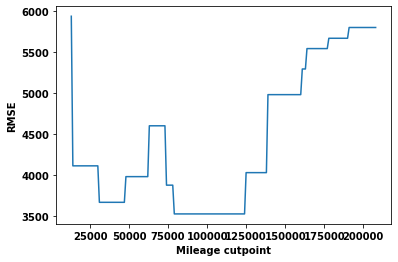

In [11]:
# Let's plot RMSE vs mileage cutpoint #
plt.plot(mileage_range, RMSE);
plt.xlabel('Mileage cutpoint');
plt.ylabel('RMSE');

Let's build a Regression Tree model.

In [12]:
# Let's encode a car as 0 and a truck as 1 #
train['vtype'] = train.vtype.map({'car':0, 'truck':1})

In [13]:
feature_cols = ['year', 'miles', 'doors', 'vtype']

X = train[feature_cols]
y = train.price

In [14]:
treereg = DecisionTreeRegressor(random_state=42)
treereg

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [15]:
# Let's use leave-one-out cross-validation (LOOCV) to estimate the RMSE for this model #
scores = cross_val_score(treereg, X, y, cv=14, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

2414.285714285714

Let's try to reduce the RMSE by tuning the model's parameters.

In [16]:
# List of values to try:
max_depth_range = list(range(1, 8))

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []

# Let's use LOOCV with each value of max_depth #
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=42)
    MSE_scores = cross_val_score(treereg, X, y, cv=14, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

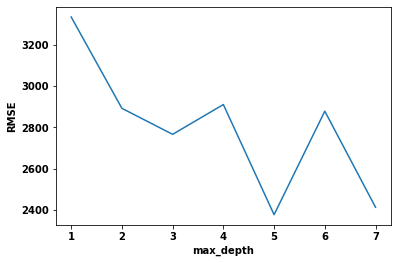

In [17]:
# Let's visualize our results from the previous cell by plotting RMSE vs max_depth #
plt.plot(max_depth_range, RMSE_scores);
plt.xlabel('max_depth');
plt.ylabel('RMSE');

In [18]:
# A max_depth of 5 was best, so let's fit a tree using that parameter #
treereg = DecisionTreeRegressor(max_depth=5, random_state=42)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [19]:
# 'Gini importance' of each feature: the (normalized) total reduction of error brought by that feature #
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})

,feature,importance
0,year,0.979999
1,miles,0.017973
2,doors,0.002029
3,vtype,0.000000


In [20]:
# Let's create a Tree Diagrama using Graphviz #
export_graphviz(treereg, out_file='./tree_vehicles.dot', feature_names=feature_cols)

In [21]:
# Let's convert this dot file into PNG so we can see it #
!dot -Tpng tree_vehicles.dot -o tree_vehicles.png

![Tree for vehicle data](tree_vehicles.png)

Now that our model is trained, let's load in our testing vehicle dataset to begin making predictions.

In [22]:
test = pd.read_csv('./data/vehicles_test.csv')
test['vtype'] = test.vtype.map({'car':0, 'truck':1})
test

,price,year,miles,doors,vtype
0,3000,2003,130000,4,1
1,6000,2005,82500,4,0
2,12000,2010,60000,2,0


In [23]:
# Let's use the trained model to make predictions on the testing data #
X_test = test[feature_cols]
y_test = test.price

y_pred = treereg.predict(X_test)
y_pred

array([ 5000.,  5000., 14000.])

In [24]:
# Let's calculate the RMSE of our predictions #
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

1732.0508075688772

The previous model was good for making predictions with continuous values (regression). Now, let's look at creating a model to make predictions with discrete values (classification). Let's begin by loading in the titanic dataset.

In [25]:
titanic = pd.read_csv('./data/titanic.csv')

In [26]:
titanic.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
632,633,1,1,"Stahelin-Maeglin, Dr. Max",male,32.0,0,0,13214,30.5000,B50,C
446,447,1,2,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5000,NaN,S
531,532,0,3,"Toufik, Mr. Nakli",male,NaN,0,0,2641,7.2292,NaN,C
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.5500,NaN,S
499,500,0,3,"Svensson, Mr. Olof",male,24.0,0,0,350035,7.7958,NaN,S


In [27]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [28]:
# Let's fill in the missing values for age with the median age #
titanic.Age.fillna(titanic.Age.median(), inplace=True)

In [29]:
# Let's encode female as 0 and male as 1 #
titanic['Sex'] = titanic.Sex.map({'female':0, 'male':1})

In [30]:
# Let's create a dataframe of dummy variables for the embarked column #
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix='Embarked')
embarked_dummies.drop(embarked_dummies.columns[0], axis=1, inplace=True)

In [31]:
# Let's concatenate the original dataframe and the dummy dataframe #
titanic = pd.concat([titanic, embarked_dummies], axis=1)

In [32]:
# Let's check out the updated dataframe #
titanic.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_Q,Embarked_S
426,427,1,2,"Clarke, Mrs. Charles V (Ada Maria Winfield)",0,28.0,1,0,2003,26.0000,NaN,S,0,1
178,179,0,2,"Hale, Mr. Reginald",1,30.0,0,0,250653,13.0000,NaN,S,0,1
72,73,0,2,"Hood, Mr. Ambrose Jr",1,21.0,0,0,S.O.C. 14879,73.5000,NaN,S,0,1
574,575,0,3,"Rush, Mr. Alfred George John",1,16.0,0,0,A/4. 20589,8.0500,NaN,S,0,1
195,196,1,1,"Lurette, Miss. Elise",0,58.0,0,0,PC 17569,146.5208,B80,C,0,0


- **Survived:** 0 = died, 1 = survived (target variable)
- **Pclass:** 1 = first class, 2 = second class, 3 = third class
- **Sex:** 0 = female, 1 = male
- **Age:** Numeric value
- **Embarked:** C or Q or S

Let's build a Classification Tree model.

In [33]:
feature_cols = ['Pclass', 'Sex', 'Age', 'Embarked_Q', 'Embarked_S']

X = titanic[feature_cols]
y = titanic.Survived

In [34]:
# List of values to try:
max_depth_range = list(range(1, 8))

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []

# Let's use LOOCV with each value of max_depth #
for depth in max_depth_range:
    treeclf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    MSE_scores = cross_val_score(treeclf, X, y, cv=14, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

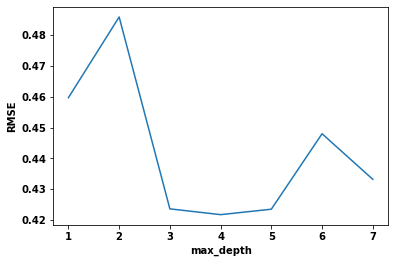

In [35]:
# Let's visualize our results from the previous cell by plotting RMSE vs max_depth #
plt.plot(max_depth_range, RMSE_scores);
plt.xlabel('max_depth');
plt.ylabel('RMSE');

In [36]:
treeclf = DecisionTreeClassifier(max_depth=4, random_state=42)
treeclf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [37]:
export_graphviz(treeclf, out_file='./tree_titanic.dot', feature_names=feature_cols)

In [38]:
!dot -Tpng tree_titanic.dot -o tree_titanic.png

![Tree for Titanic data](tree_titanic.png)

In [39]:
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

,feature,importance
0,Pclass,0.234769
1,Sex,0.617050
2,Age,0.108862
3,Embarked_Q,0.004251
4,Embarked_S,0.035068


Let's try to predict the outcome of a March Madness game.

In [40]:
df = pd.read_csv('./data/ncaa.csv')

In [41]:
df.sample(5).T

,4049,16310,13495,4693,7945
AST,11.6923,10.5385,13.25,15.3182,13.3
AST_Diff,2.44231,-3.98154,1.93421,5.11818,1.3
BLK,4,4.07692,3.625,6.40909,4.8
BLK_Diff,2.375,0.756923,-0.585526,1.40909,2.55
Coach,rodney_terry,patrick_chambers,tom_izzo,scott_drew,steve_fisher
DR,23.6923,22.3846,22.375,25.6364,24.7333
DR_Diff,2.94231,-5.33538,-1.94079,1.33636,3.10833
FGP,0.450315,0.367339,0.416153,0.474114,0.462815
FGP3,0.352429,0.32742,0.338738,0.394884,0.330608
FGP3_Diff,-0.0347979,-0.0873749,-0.010964,0.0325313,0.0936497


In [42]:
df.isnull().sum()

AST               0
AST_Diff          0
BLK               0
BLK_Diff          0
Coach             0
DR                0
DR_Diff           0
FGP               0
FGP3              0
FGP3_Diff         0
FGP_Diff          0
FTP               0
FTP_Diff          0
Loc               0
OR                0
OR_Diff           0
OtherTeamID       0
PPG               0
PPG_Diff          0
Rank           8597
Rank_Diff         0
Result            0
SEED_Diff         0
STL               0
STL_Diff          0
Season            0
Seed              0
TeamID            0
dtype: int64

In [43]:
# Let's drop the rank attribute as it will not help with our predictions (due to the many null values)#
df.drop('Rank', axis=1, inplace=True)

In [44]:
# Let's create dummies for the location attribute to use in our model #
location_dummies = pd.get_dummies(df['Loc'])
location_dummies.head(3)

,A,H,N
0,0,0,1
1,0,0,1
2,0,1,0


In [45]:
location_dummies.drop('N', axis=1, inplace=True)
df = pd.concat([df.drop('Loc', axis=1), location_dummies], axis=1)

In [46]:
X = df.drop(['Coach', 'TeamID', 'OtherTeamID', 'Result'], axis=1)
y = df.Result

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [48]:
# List of values to try:
max_depth_range = list(range(1, 11))

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []

# Let's use LOOCV with each value of max_depth #
for depth in max_depth_range:
    dec_tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    MSE_scores = cross_val_score(dec_tree, X, y, cv=14, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

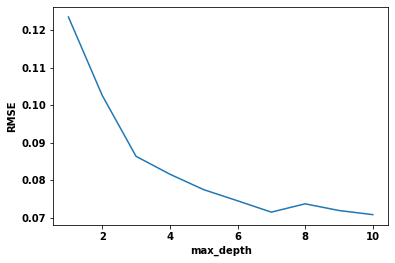

In [49]:
# Let's visualize our results from the previous cell by plotting RMSE vs max_depth #
plt.plot(max_depth_range, RMSE_scores);
plt.xlabel('max_depth');
plt.ylabel('RMSE');

In [50]:
# Let's use a max depth of 7 as it seems to fluctuate afterwards #
dec_tree = DecisionTreeClassifier(max_depth=7, random_state=42)

In [51]:
dec_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [52]:
export_graphviz(dec_tree, out_file='./tree_ncaa.dot', feature_names=X.columns)

In [53]:
!dot -Tpng tree_ncaa.dot -o tree_ncaa.png

![Tree for March Madness data](tree_ncaa.png)

In [54]:
# Let's take a look at how accurate our predictions are with this model #
dec_tree.score(X_test, y_test)

0.9951540996317115